# 检测视频烟火

In [7]:
import numpy as np
import cv2
import os
import time
import lib.video.fire_detect as fire_detect 
import importlib
importlib.reload(fire_detect)

CATEGORIES = ['Fire', 'NoFire']

module_path = '{}/fire_best.pkh'.format('/project')
detect = fire_detect.FireDetect(module_path=module_path)

Using GPU


In [9]:
import numpy as np
import cv2
import os
import time


# path = os.path.join('/project','data','test','object','video','fire')
# file_name = ['FireVid20.mp4','FireVid24.mp4','FireVid52.mp4']
path = os.path.join('/project','data','test','object','video','nofire')
img_save_path = os.path.join('/project','temp')
title = 'NoFire'

file_name = ['NoFire_2.flv','NoFire_1.mp4']
video_file = os.path.join(path, file_name[0])
cap = cv2.VideoCapture("https://122b09cc657a4d0ba64dd7a46e4c682f.apigw.cn-south-1.huaweicloud.com/live/work013?app=vis&stream=twstream")

start_time = time.time()
print('begin read mp4')
number = 0
current_states = -1
while(cap.isOpened()):
    ret,frame = cap.read()
    if ret == False:
        break
    elif ret == True:
        
        if number % 20 == 0:
            cv2.imwrite('{}_V3_{}.png'.format(os.path.join(img_save_path, title), number),frame)
        if number % 20 == 0:
            pred = detect.detect(frame)
            flag = CATEGORIES[pred]
            if pred != current_states:
                print('detect fire -->{}'.format(flag))
                current_states = pred
            
        number = number + 1
print('over read , time -->{}, frame number -->{}'.format(time.time() - start_time, number))

begin read mp4
detect fire -->NoFire
detect fire -->Fire
detect fire -->NoFire
detect fire -->Fire
detect fire -->NoFire
detect fire -->Fire
detect fire -->NoFire
detect fire -->Fire
detect fire -->NoFire


KeyboardInterrupt: 

# 视频推流

In [14]:
# 推送视频内容到流媒体
import subprocess as sp
import cv2
rtmpUrl = "rtmp://139.9.85.162:27861/vis/twstream"
video_path = '/project/data/test/object/video/fire/FireVid35.mp4'
cap = cv2.VideoCapture(video_path)

# Get video information
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# ffmpeg command
command = ['ffmpeg',
        '-y',
        '-f', 'rawvideo',
        '-vcodec','rawvideo',
        '-pix_fmt', 'bgr24',
        '-s', "{}x{}".format(width, height),
        '-r', str(fps),
        '-i', '-',
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-preset', 'ultrafast',
        '-f', 'flv', 
        rtmpUrl]

p = sp.Popen(command, stdin=sp.PIPE)
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        print("Opening camera is failed")
        p.terminate()
        break
    p.stdin.write(frame.tostring())
p.terminate()


BrokenPipeError: [Errno 32] Broken pipe

# 人脸检测

img shape--> (500, 1000, 3)
time --> 1.853785753250122


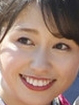

In [61]:
import numpy as np
import cv2
# import tensorflow as tf
import random
from PIL import Image
from mtcnn.mtcnn import MTCNN as mtcnn
import time

image_path = "/project/data/object/emotion/w1000h500z1l0t0q100c02.jpg"
img = Image.open(image_path)
img = np.array(img)
img_source = img.copy()
print('img shape-->', img.shape)

detector = mtcnn()
start_time = time.time()
detected = detector.detect_faces(img)
print('time -->', time.time()-start_time)
crop_img_list = []
for idx in range(len(detected)):
    box = detected[idx]["box"]
    res_img = cv2.rectangle(img, (box[0],box[1]),(box[0]+box[2],box[1]+box[3]), 0, 1)
    crop_img_list.append(img_source[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])
    keypoints = detected[idx]["keypoints"]
    res_img = cv2.circle(res_img, keypoints['left_eye'], 1, 255, 4)
    res_img = cv2.circle(res_img, keypoints['right_eye'], 1, 255, 4)
    res_img = cv2.circle(res_img, keypoints['nose'], 1, 255, 4)
    res_img = cv2.circle(res_img, keypoints['mouth_left'], 1, 255, 4)
    res_img = cv2.circle(res_img, keypoints['mouth_right'], 1, 255, 4)

res_img = Image.fromarray(res_img)
# res_img
crop_img = Image.fromarray(crop_img_list[0])
crop_img

In [10]:
?mtcnn

# 检测表情

img shape --> (75, 59)
img size --> (59, 75)
torch.Size([1, 3, 48, 48])
tensor([[ 0.4463, -0.8574,  1.2557, -0.4189,  0.4940, -0.8210,  0.0842]],
       device='cuda:0', grad_fn=<AddmmBackward>)
predicted --> tensor([2], device='cuda:0')
fear


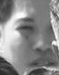

In [96]:
# 华为云训练出来的tensortflow模型
from emotion.vgg import VGG
import emotion.transforms as transforms
import torch
import cv2
import numpy as np

transform_img = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor()
])

label = ['anger','disgust','fear','happy','sadness','surprise','contempt']

path = '/project'
use_cuda = torch.cuda.is_available()
net = VGG('VGG19')
net_static = torch.load('{}/emotion_private_best.t7'.format(path))['net']
net.load_state_dict(net_static)
if use_cuda:
    net.cuda()
net.eval()
image_path = "/project/data/object/emotion/S011_003_00000013.png"


# img = Image.open(image_path)
crop_img = Image.fromarray(crop_img_list[7]).convert('L')
# crop_img
img = crop_img

img_source = img.copy()

img = np.array(img)
print('img shape -->', img.shape)
if len(img.shape) == 2:
    img = img[:, :, np.newaxis]
    img = np.concatenate((img, img, img), axis=2)
    
img = Image.fromarray(img)
print('img size -->', img.size)

inputs = transform_img(img)
inputs = inputs.unsqueeze(0)
print(inputs.size())
if use_cuda:
    inputs = inputs.cuda()

preds = net(inputs)
print(preds)
_, predicted = torch.max(preds, 1)
print('predicted -->', predicted)
print(label[predicted.item()])

img_source


In [84]:
ss = torch.load('{}/emotion_private_best.t7'.format(path))

In [86]:
ss['net']

OrderedDict([('features.0.weight', tensor([[[[-0.0952, -0.0718,  0.1041],
                        [-0.0603,  0.0486,  0.1990],
                        [-0.0063, -0.0567, -0.0480]],
              
                       [[-0.1732, -0.0498,  0.0907],
                        [-0.0627,  0.1200,  0.1951],
                        [-0.0645, -0.0306,  0.0065]],
              
                       [[-0.1721, -0.0298,  0.0766],
                        [-0.0166,  0.1075,  0.1910],
                        [-0.0784, -0.0575, -0.0054]]],
              
              
                      [[[-0.0134,  0.0153, -0.0323],
                        [ 0.0261, -0.0100,  0.0261],
                        [ 0.0011, -0.0063,  0.0445]],
              
                       [[-0.0546,  0.0358,  0.0361],
                        [ 0.0013, -0.0016, -0.0115],
                        [-0.0280,  0.0224,  0.0131]],
              
                       [[ 0.0261,  0.0243,  0.0504],
                        [ 0.0347,  